In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from scipy.optimize import curve_fit
from lmfit import Model, minimize, Parameters, report_fit
from lmfit.models import GaussianModel, PolynomialModel
import astropy.units as u
import pandas as pd

In [13]:
def doubleGauss(x, h1, c1, w1, h2, c2, w2):
    G = h1*np.exp(-(x-c1)**2/(2*w1**2)) + h2*np.exp(-(x-c2)**2/(2*w2**2))
    return G



In [14]:
# Setup a pandas dataframe to save all the variables we'd like
# eventually plot.

resultsTable = pd.DataFrame(np.array([[0, 
                                     0, 
                                     0, 
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0, 
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0, 
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0]]),
                           columns=['l (deg)', 
                                    'b (deg)', 
                                    'T_peak (K)', 
                                    'v_lsr (km/s)',
                                   'FWHMS (km/s)',
                                   'W(OH)_67 (K km/s)',
                                   'sigma W(OH)_67 (K km/s)',
                                   'N(OH)_67 (cm^-2)',
                                   '\sigma N(OH)_67 (cm^-2)',
                                   'N(H2)_OH_67 (cm^-2)',
                                   '\sigma N(H2)_OH_67 (cm^-2)',
                                   'T_peak (K)',
                                   'v_lsr (km/s)',
                                   'FWHM (km/s)',
                                   'W(OH)_65 (K km/s)',
                                   '\sigma W(OH)_65 (K km/s)',
                                   'N(OH)_65 (cm^-2)',
                                   '\sigma N(OH)_65 (cm^-2)',
                                   'N(H2)_{OH_65} (cm^-2)',
                                   '\sigma N(H2)_OH_65 (cm^-2)',
                                   'T_peak (K)',
                                   'v_lsr (km/s)',
                                   'FWHM (km/s)',
                                   'W(HI) (K km/s)',
                                   '\sigma W(HI) (K km/s)',
                                   'N(HI) (cm^-2)',
                                   '\sigma N(HI) (cm^-2)',
                                   'T_peak (K)',
                                   'v_lsr (km/s)',
                                   'FWHM (km/s)',
                                   'W(CO) (K km/s)',
                                   '\sigma W(CO) (K km/s)',
                                   'N(H2)_{CO} (cm^-2)',
                                   '\sigma N(H2)_CO (cm^-2)',
                                   ])

(123.5, 193.63)


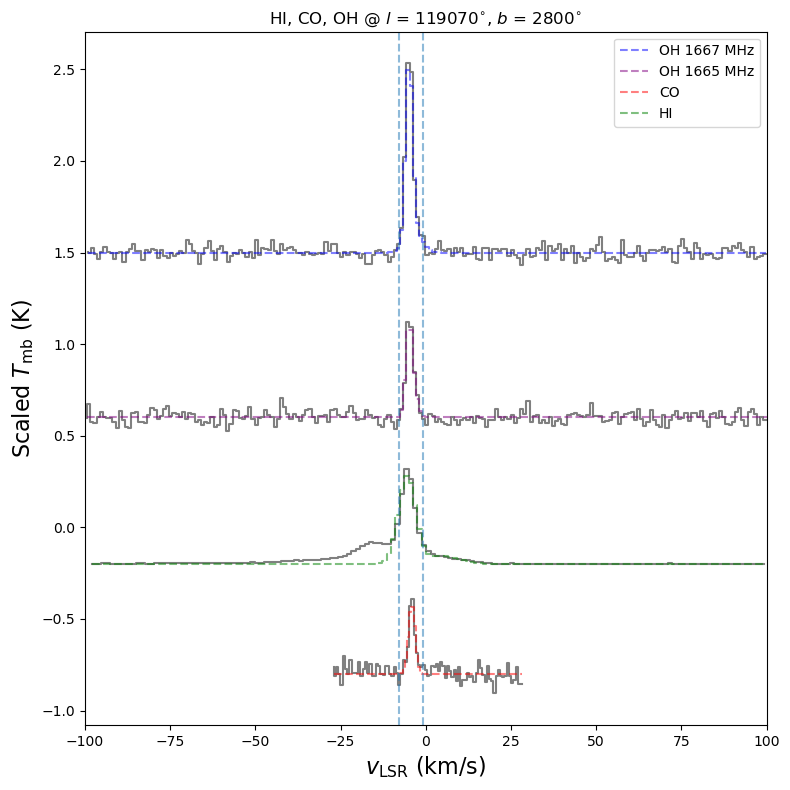

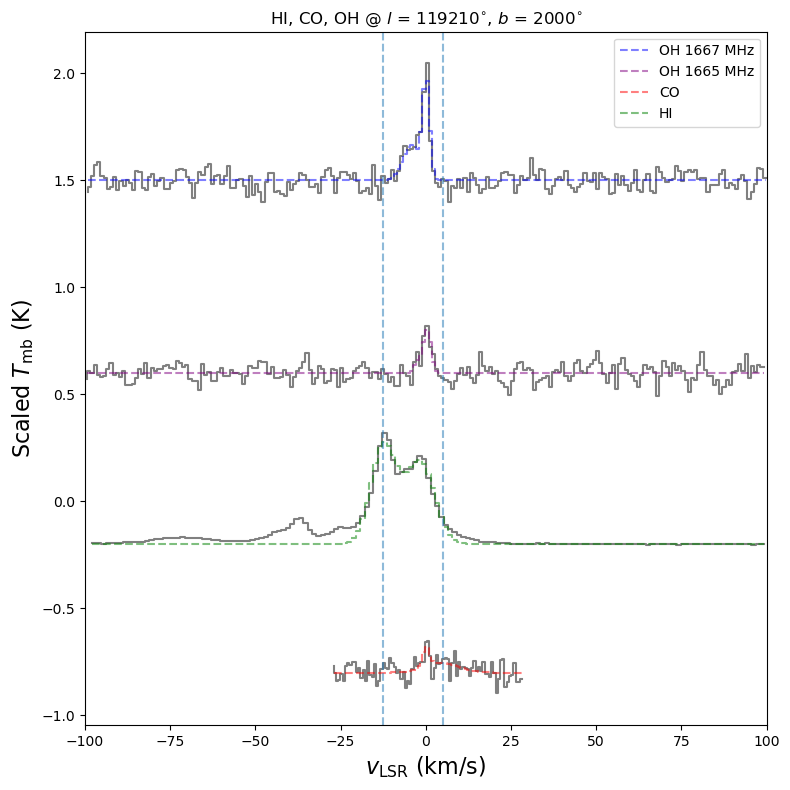

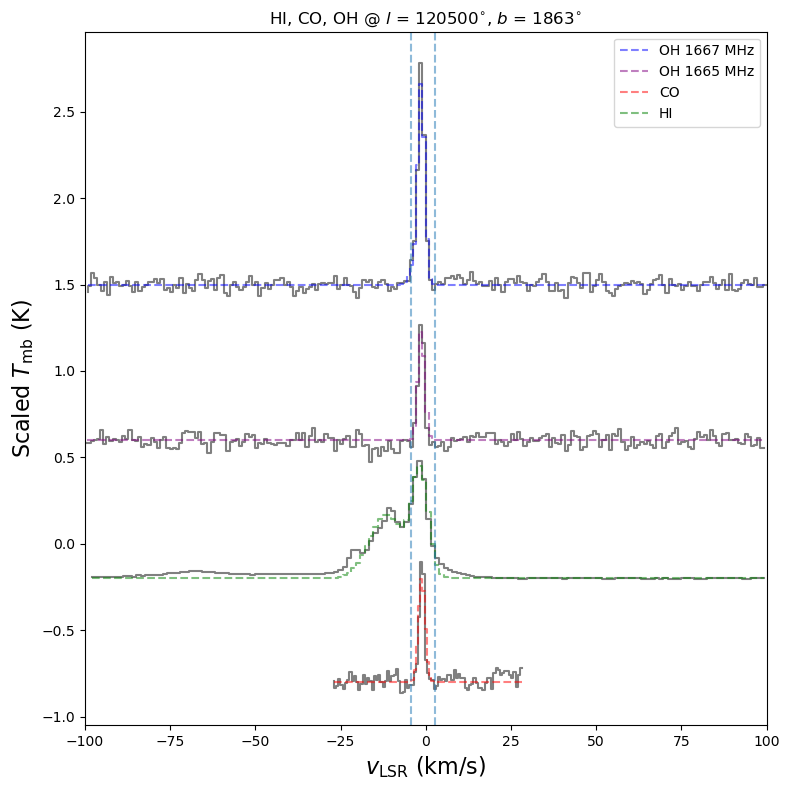

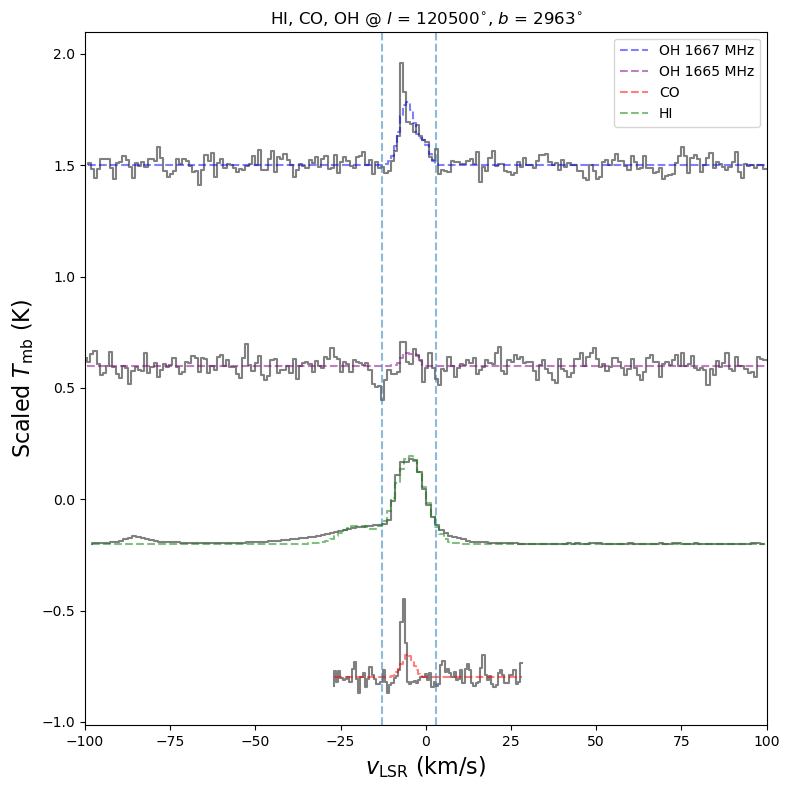

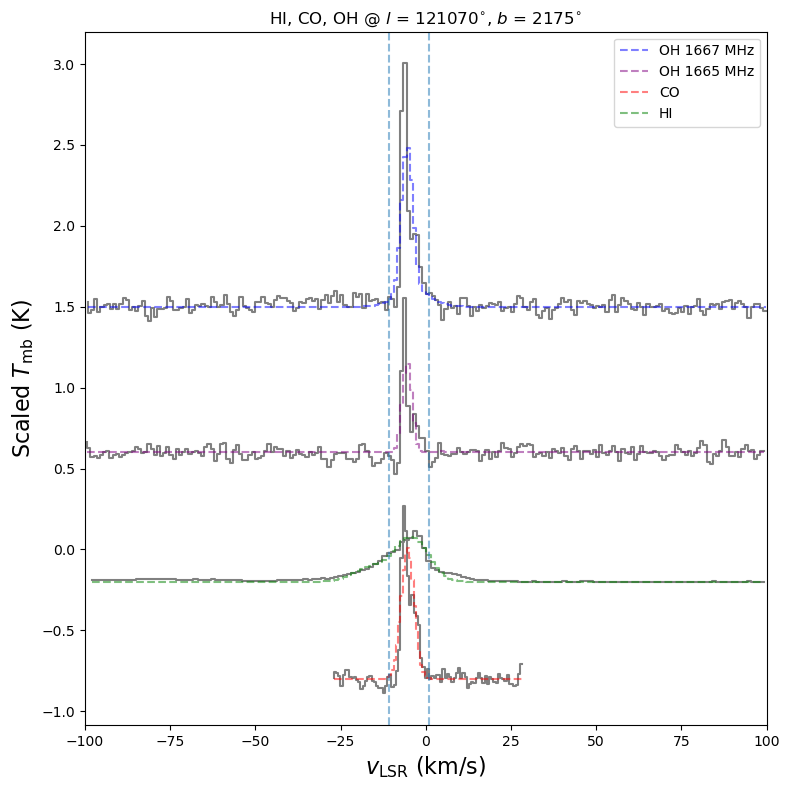

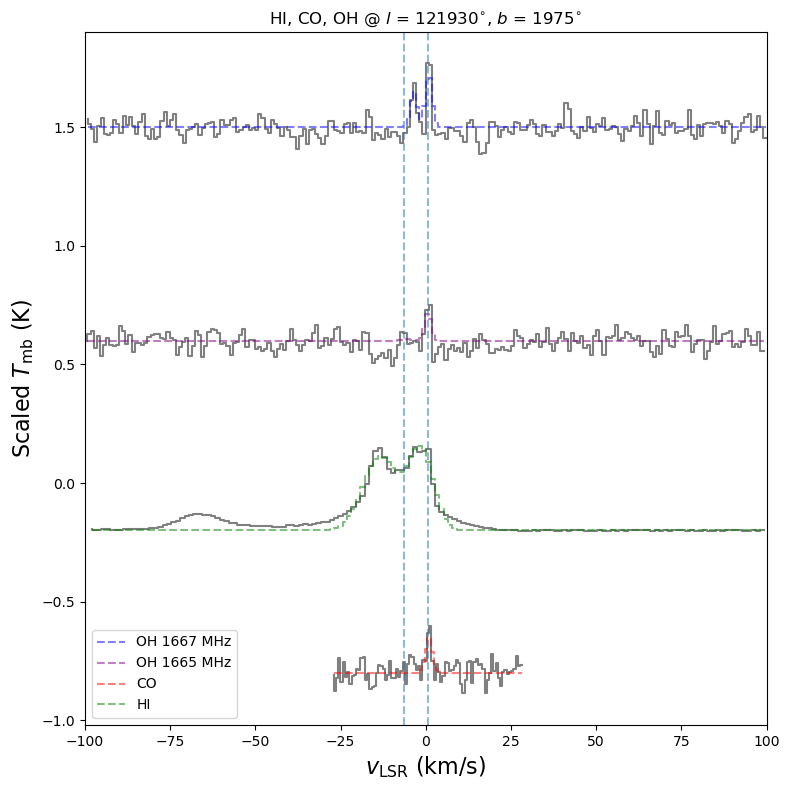

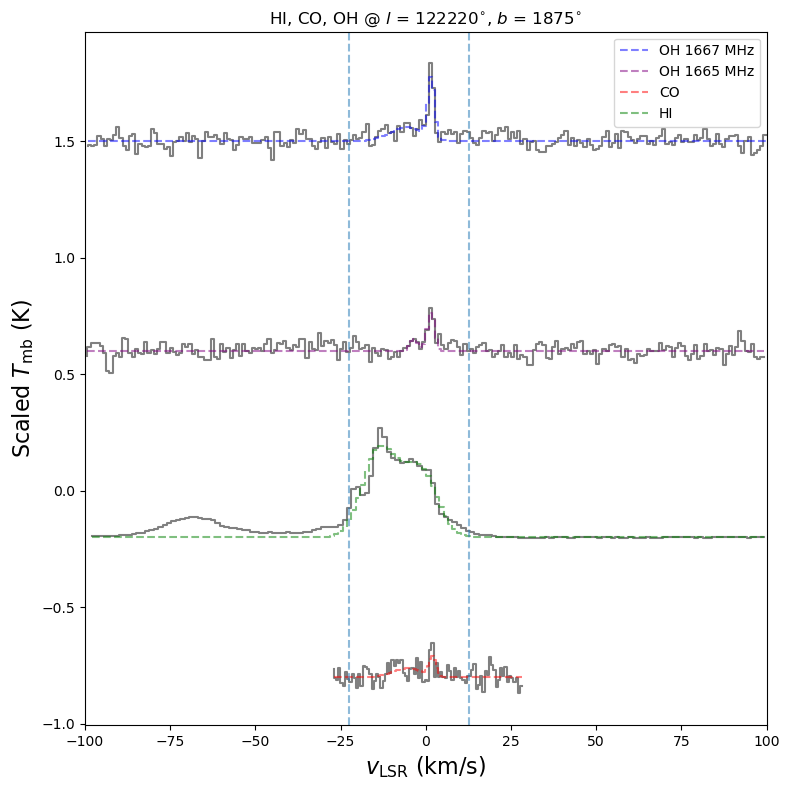

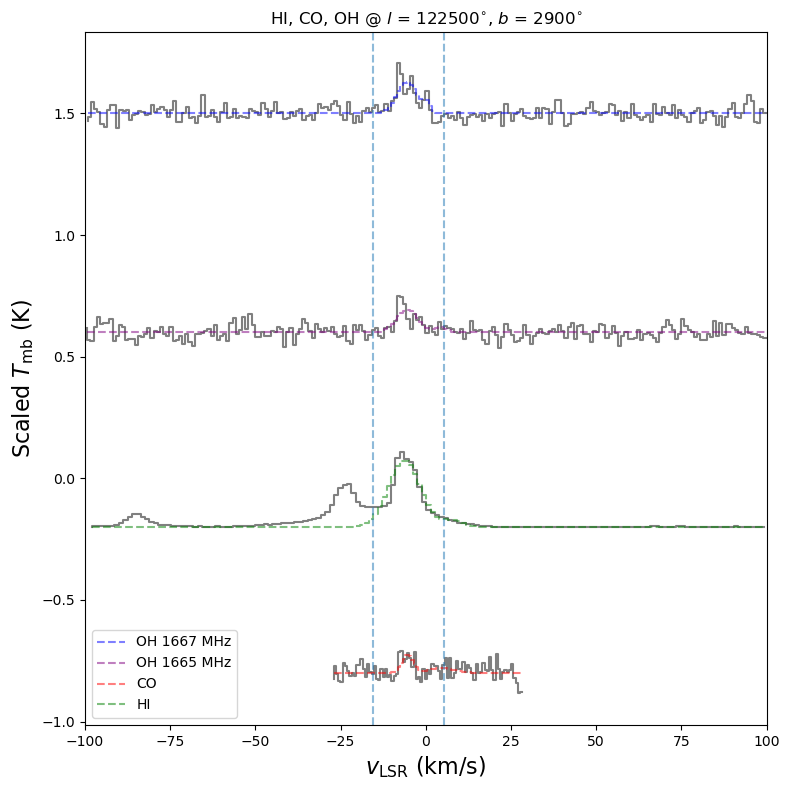

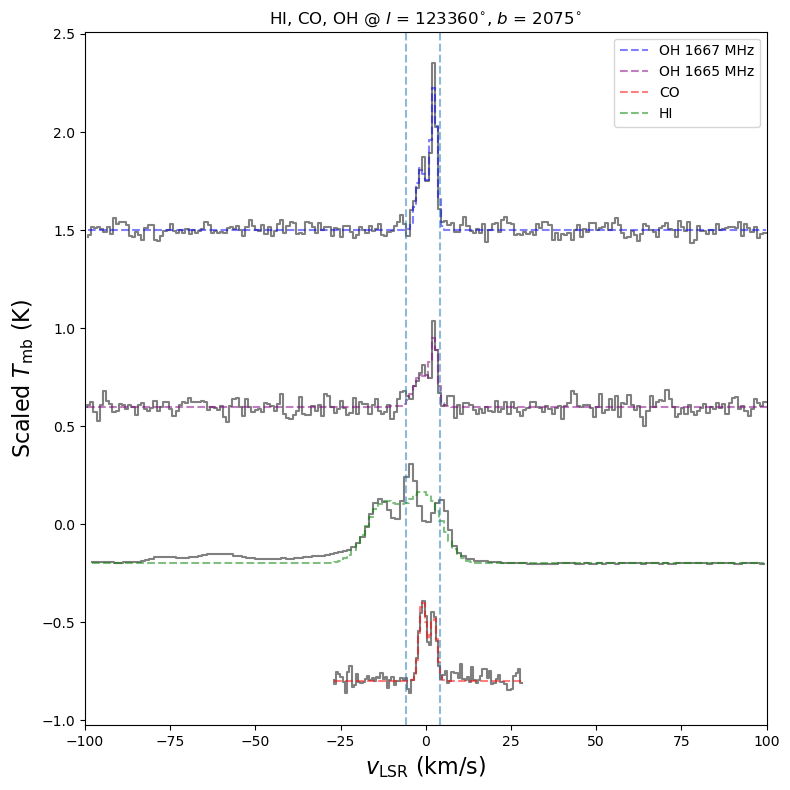

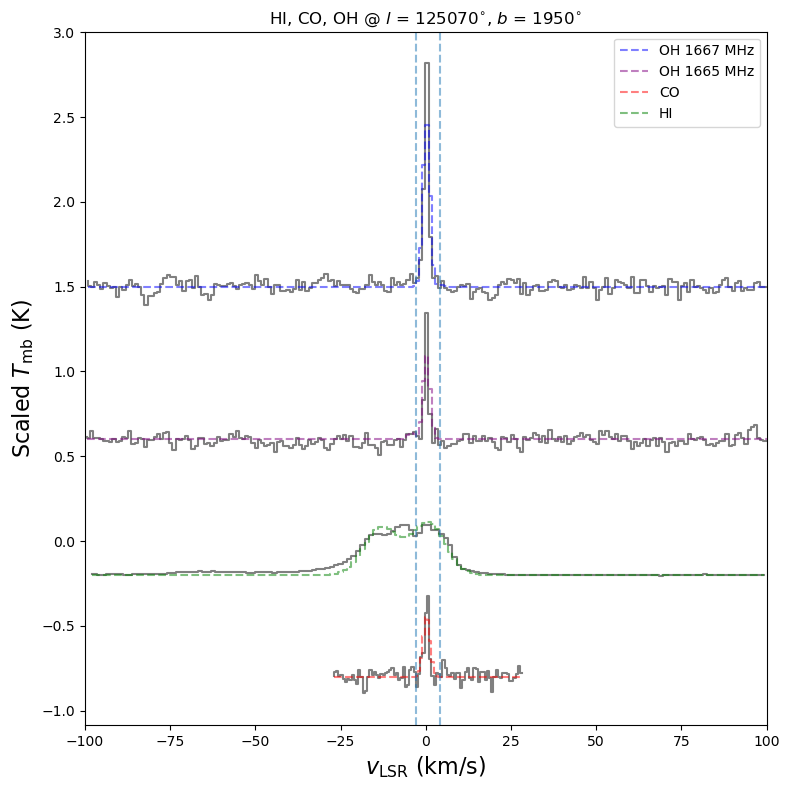

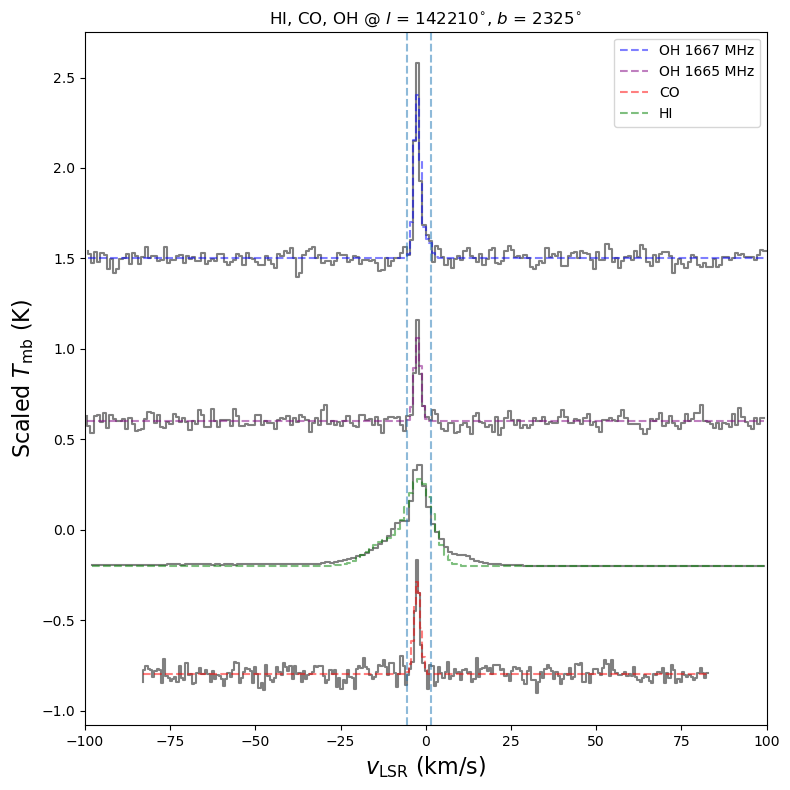

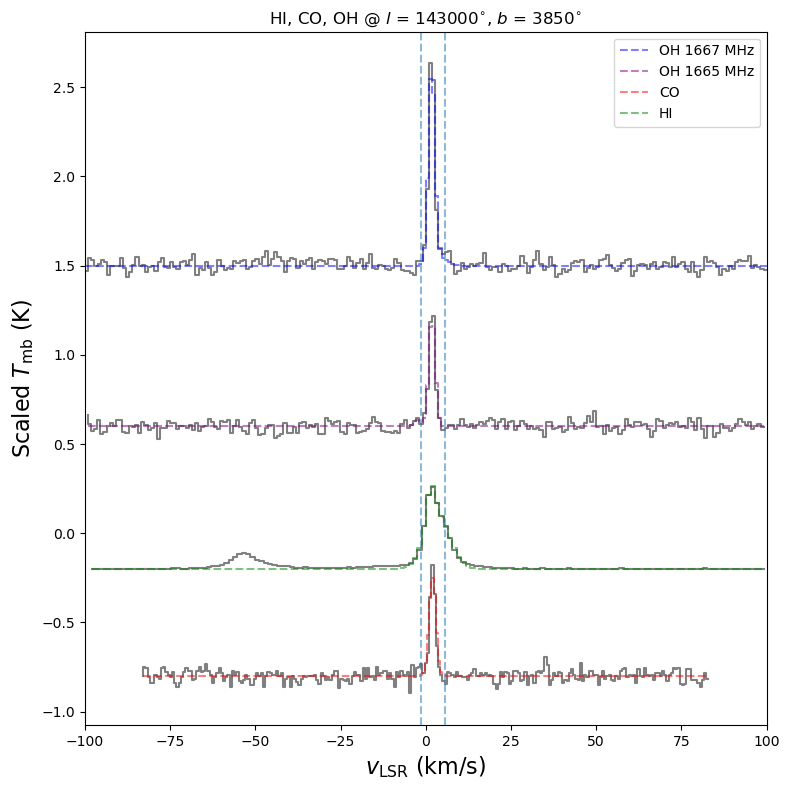

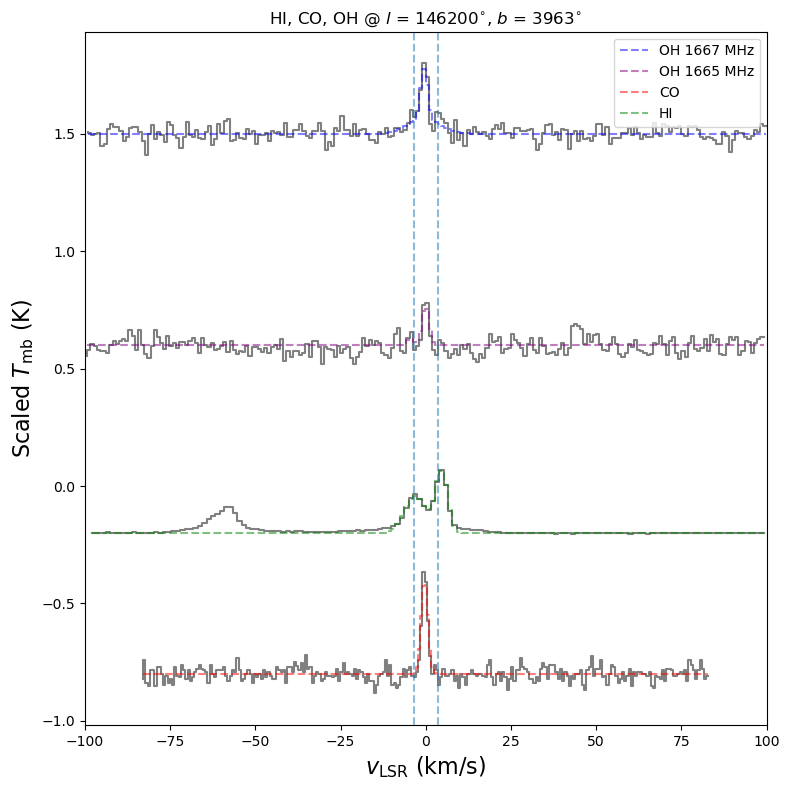

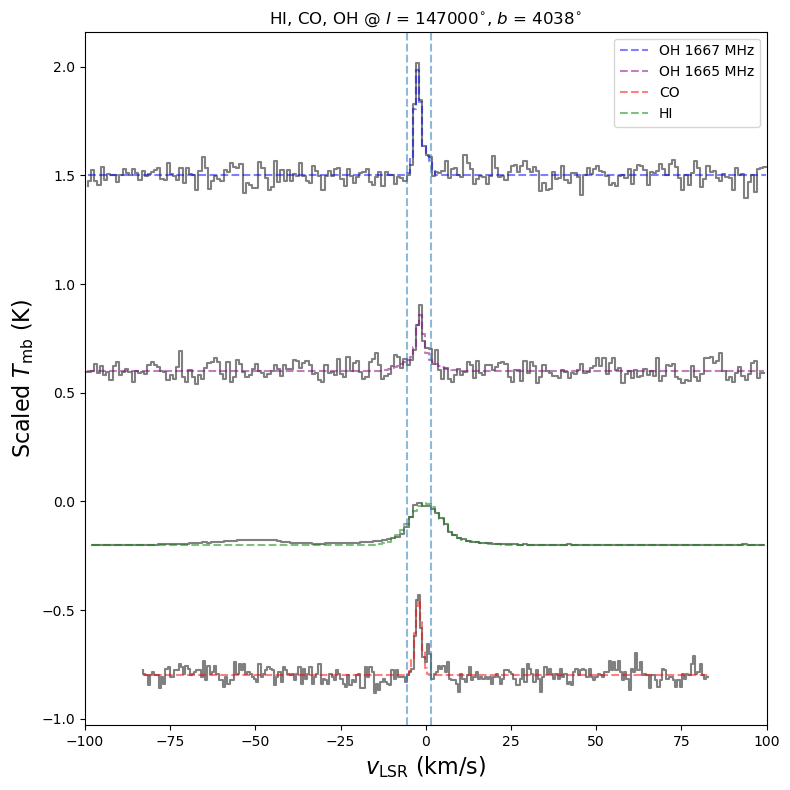

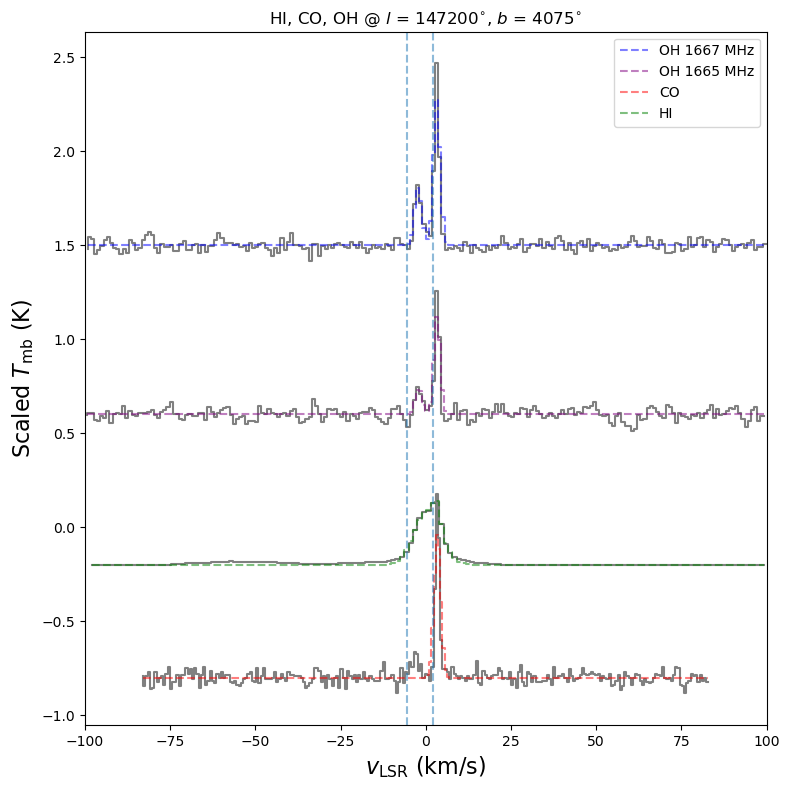

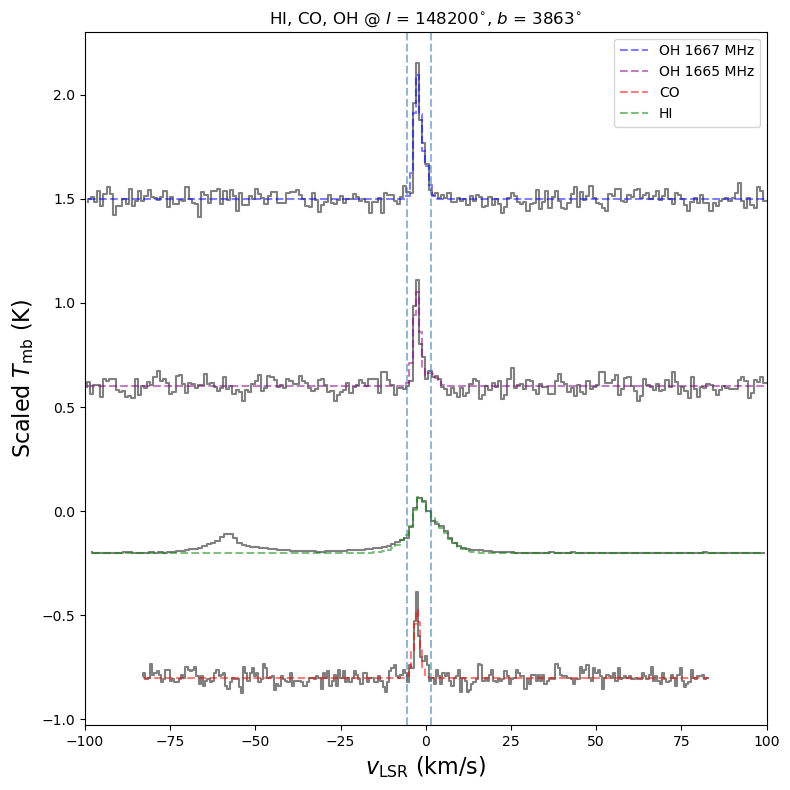

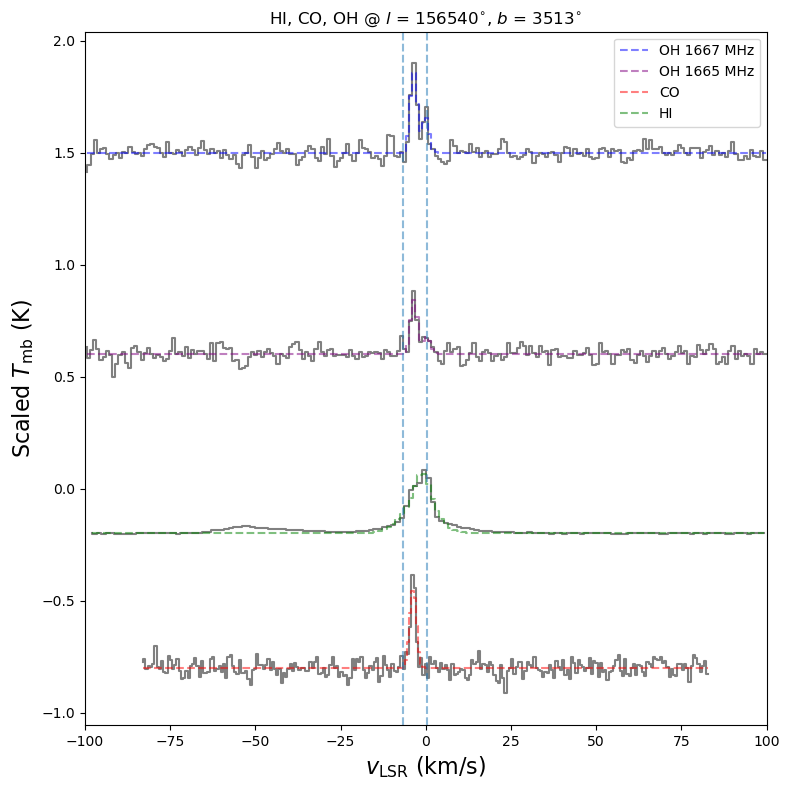

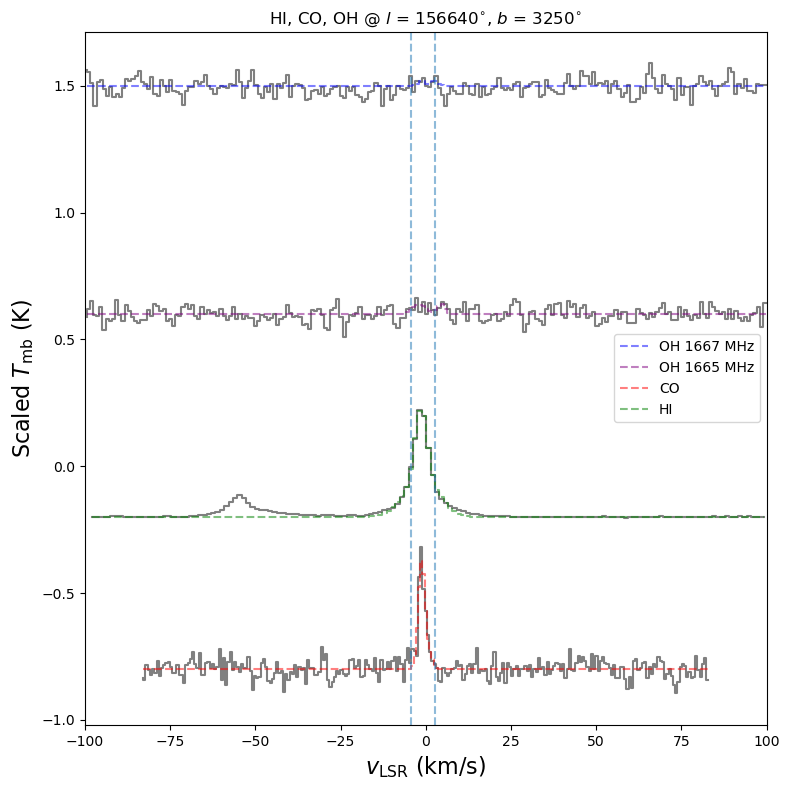

In [23]:
# Setup constants for column densities, read e.g. Busch 2019, Busch 2021:

# Constant "C" definitions, use these to convert to N(OH) and N(HI):
C_1667 = 2.257 * 10e14 * u.cm**-2 / (u.K * u.km/u.s)
C_1665 = 4 * 10e14 * u.cm**-2 / (u.K * u.km/u.s)
C_HI = 1.82 * 10e18 * u.cm**-2 / (u.K * u.km/u.s)

# Constant X(CO) definitions, use to convert W(CO) to N(H2)
Xco = 2 * 10e20 * u.cm**-2 / (u.K * u.km/u.s)

# Abundance ratio of OH/H2, used to convert N(OH) to N(H2)
Xoh = 1e-7

# What is f? The background correction factor? The contrast between Tcmb and Tex? It is slightly different for 1667 and 1665.
Tcmb = 2.7
Tex_67 = 5
Tex_65 = 4
f_67 = Tex_67/(Tex_67-Tcmb)
f_65 = Tex_65/(Tex_65-Tcmb)


# Put all coordinates in a list of tuples:
# lb = [(119.07, 28), (), (), (), etc...]
lb = [(119.07, 28), (119.21, 20), (120.5, 18.63), (120.5, 29.63), (121.07, 21.75), (121.93, 19.75), (122.22, 18.75), (122.5, 29), (123.36, 20.75), (123.5, 193.63), (125.07, 19.5), (142.21, 23.25), (143, 38.5), (146.2, 39.63), (147, 40.38), (147.2, 40.75), (148.2, 38.63), (156.54, 35.13), (156.64, 32.5)]

for coords in lb:
    # Read the longitude of the pointing:
    l = coords[0]
    l = str(int(l*1000))
    
    # Read the latitude of the pointing:
    b = coords[1]
    b = str(int(b*100))
    
    # load data, multiply coordinates by 1000 and 100 
    # and force them to be integer then strings, 
    # then load them using string concatenation:
    try:
        OH67 = ascii.read('C:/Users/seven/OneDrive/Documents/DustSurvey/OH' + l + 'p' + b + '_67basesub.txt')
        OH65 = ascii.read('C:/Users/seven/OneDrive/Documents/DustSurvey/OH' + l + 'p' + b + '_65basesub.txt')
        HI = ascii.read('C:/Users/seven/OneDrive/Documents/DustSurvey/HI' + l + 'p' + b + '.txt', data_start = 13, data_end = 167)
        CO = ascii.read('C:/Users/seven/OneDrive/Documents/DustSurvey/CO' + l + 'p' + b + '.txt')
    except:
        print(coords)
        continue

    # All the data is now loaded, now we define our velocity and temperatures like this:
    vel67 = OH67['col1']
    Ta67 = OH67['col2']
    vel65 = OH65['col1']
    Ta65 = OH65['col2']
    velHI = HI['col1']
    TaHI = HI['col2']
    velCO = CO['col1']
    TaCO = CO['col2']
    
    deltaV67 = (vel67[1]-vel67[0])
    deltaV65 = (vel65[1]-vel65[0])
    deltaVCO = (velCO[1]-velCO[0])
    deltaVHI = (velHI[1]-velHI[0])
    
    # Setup indicies for std calculation of spectra:
    igoodNoise67 = np.where((vel67 >= -150) & (vel67 <= -30))[0]
    igoodNoise65 = np.where((vel65 >= -150) & (vel65 <= -30))[0]
    igoodNoiseCO = np.where((velCO >= 5) & (velCO <= 30))
    igoodNoiseHI = np.where((velHI >= 50) & (velHI <= 100))
    
    # Setup indicies for Gaussian fitting:
    igood67 = np.where((vel67 >= -25) & (vel67 <= 25))[0]
    igood65 = np.where((vel65 >= -25) & (vel65 <= 25))[0]
    igoodCO = np.where((velCO >= -25) & (velCO <= 25))
    igoodHI = np.where((velHI >= -25) & (velHI <= 25))
    # Perform Gaussian fitting of 1667:
    #Guesses: p0 = height1, center1, width 1, height2, center2, width2
    parameters67, covariance67 = curve_fit(doubleGauss, vel67[igood67], Ta67[igood67], p0= [0.05, -1, 4, 0.05, 0, 5], bounds = ([0, -5, 1, 0, -5, 1], [0.5, 5, 5, 0.5, 5, 5]))
    
    fit67A = parameters67[0] # amplitude
    fit67B = parameters67[1] # centroid
    fit67C = parameters67[2] # sigma
    fit67D = parameters67[3]
    fit67E = parameters67[4]
    fit67F = parameters67[5]
    fit_67y = doubleGauss(vel67, fit67A, fit67B, fit67C, fit67D, fit67E, fit67F)
    
    # Perform Gaussian fitting of 1665:
    parameters65, covariance65 = curve_fit(doubleGauss, vel65[igood65], Ta65[igood65], p0= [0.05, -1, 4, 0.05, 0, 5], bounds = ([0, -5, 1, 0, -5, 1], [0.5, 5, 5, 0.5, 5, 5]))
    fit65A = parameters65[0]
    fit65B = parameters65[1]
    fit65C = parameters65[2]
    fit65D = parameters65[3]
    fit65E = parameters65[4]
    fit65F = parameters65[5]
    fit_65y = doubleGauss(vel65, fit65A, fit65B, fit65C, fit65D, fit65E, fit65F)
    
    # Perform Gaussian fitting of CO:
    parametersCO, covarianceCO = curve_fit(doubleGauss, velCO[igoodCO], TaCO[igoodCO], p0= [3, 0, 3, 3, 0, 3], bounds = ([0, -5, 1, 0, -5, 1], [10, 5, 5, 10, 5, 5]))
    fitCOA = parametersCO[0]
    fitCOB = parametersCO[1]
    fitCOC = parametersCO[2]
    fitCOD = parametersCO[3]
    fitCOE = parametersCO[4]
    fitCOF = parametersCO[5] 
    fit_COy = doubleGauss(velCO, fitCOA, fitCOB, fitCOC, fitCOD, fitCOE, fitCOF)
    
    # Perform Gaussian fitting of HI:
    parametersHI, covarianceHI = curve_fit(doubleGauss, velHI[igoodHI], TaHI[igoodHI], p0= [23, -1, 3, 23, 0, 3], bounds = ([0, -25, 1, 0, -25, 1], [40, 25, 5, 40, 25, 5]))
    fitHIA = parametersHI[0]
    fitHIB = parametersHI[1]
    fitHIC = parametersHI[2]
    fitHID = parametersHI[3]
    fitHIE = parametersHI[4]
    fitHIF = parametersHI[5] 
    fit_HIy = doubleGauss(velHI, fitHIA, fitHIB, fitHIC, fitHID, fitHIE, fitHIF)
    
    # Calculate integrated flux, column densities for OH 1667:
    # Create an igood for the +/- FWHM (where FWHM = 2.355*sigma (b)), for each fit:
    igoodOH67 = np.where((vel67 >= fit67B-(1.5*2.355*fit67C)) & (vel67 <= fit67B+(1.5*2.355*fit67C)))[0]
    integralOH67 = np.sum(fit_67y) * deltaV67
    err67 = np.sqrt(len(vel67[igoodOH67])) * np.std(Ta67[igoodNoise67]) * deltaV67
    # Calculate the column density from W(OH_1667):
    NOH_67 = integralOH67 * C_1667 * f_67
    NOH_67_err = err67 * C_1667 * f_67
    # Convert N(OH) to N(H2):
    NH2_oh67 = NOH_67 / Xoh
    NH2_oh67_err = NOH_67_err / Xoh
    
    # Calculate integrated flux, column densities for OH 1665:
    # Create an igood for the +/- FWHM (where FWHM = 2.355*sigma (b)), for each fit:
    igoodOH65 = np.where((vel65 >= fit65B-(1.5*2.355*fit65C)) & (vel65 <= fit65B+(1.5*2.355*fit65C)))[0]
    # Perform the integral and calculate the error:
    integralOH65 = np.sum(fit_65y) * deltaV65
    err65 = np.sqrt(len(vel65[igoodOH65])) * np.std(Ta65[igoodNoise65]) * deltaV65
    # Calculate the column density from W(OH_1665):
    NOH_65 = integralOH65 * C_1665 * f_65
    NOH_65_err = err65 * C_1665 * f_65
    # Convert N(OH) to N(H2):
    NH2_oh65 = NOH_65 / Xoh
    NH2_oh65_err = NOH_65_err / Xoh
    
    # Calculate integrated flux, CO-traced H2 column density:
    # Create an igood for the +/- FWHM (where FWHM = 1.5*2.355*sigma (b)), for each fit:
    igoodCO = np.where((velCO >= fitCOB-(1.5*2.355*fitCOC)) & (velCO <= fitCOB+(1.5*2.355*fitCOC)))[0]
    integralCO = np.sum(fit_COy) * deltaVCO
    errCO = np.sqrt(len(velCO[igoodCO])) * np.std(TaCO[igoodNoiseCO]) * deltaVCO
    # Calculate N(H2) from CO integral (W(CO)):
    NH2_CO = integralCO*Xco
    NH2_CO_err = errCO*Xco
    
    # Calculate integrated flux, and calculate HI column density:
    # Create an igood for the +/- FWHM (where FWHM = 1.5*2.355*sigma (b)), for each fit:
    igoodHI = np.where((velHI >= fitHIB-(1.5*2.355*fitHIC)) & (velHI <= fitHIB+(1.5*2.355*fitHIC)))[0]
    integralHI = np.sum(fit_HIy) * deltaVHI
    errHI = np.sqrt(len(velHI[igoodHI])) * np.std(TaHI[igoodNoiseHI]) * deltaVHI
    # Calculate N(HI) from HI integral (W(HI)):
    NHI = integralHI * C_HI
    NHI_err = errHI * C_HI
    
    #plotting
    plt.figure(figsize=(8,8))

    plt.step(vel67, (Ta67*1.05)*12 + 1.5, 'grey')
    plt.step(vel67, fit_67y*12 + 1.5, 'blue', alpha=0.5, ls = 'dashed', label = 'OH 1667 MHz')

    plt.step(vel65, (Ta65*1.05)*12+0.6, 'grey')
    plt.step(vel65, fit_65y*12+0.6, 'purple', alpha=0.5, ls = 'dashed', label = 'OH 1665 MHz')
    

    plt.step(velCO, TaCO/4-0.8, 'grey')
    plt.step(velCO, fit_COy/4-0.8, 'red', alpha=0.5, ls = 'dashed', label = 'CO')

    plt.step(velHI, TaHI/60-0.2, 'grey')
    plt.step(velHI, fit_HIy/60 -0.2, 'green', alpha=0.5, ls = 'dashed', label = 'HI')
    
    plt.xlim(-100, 100)
    #plt.ylim(-1.2, 2)
    #plt.axhline(0.6)
    #plt.axhline(-0.9)
    #plt.axhline(-0.2)
    plt.axvline(fit67B+1.5*2.355*fit67C, ls='dashed', alpha=0.5)
    plt.axvline(fit67B-1.5*2.355*fit67C, ls='dashed', alpha=0.5)
    plt.xlabel(r'$v_{\mathrm{LSR}}$ (km/s)', size=16)
    plt.ylabel(r'Scaled $T_{\mathrm{mb}}$ (K)', size=16)
    plt.title(r'HI, CO, OH @ $l$ = ' + l + '$^{\circ}$, $b$ = ' + b + '$^{\circ}$') #need to set title with lb tuple
    plt.legend()
    plt.tight_layout()
    
    # Add a row to the resultsTable of the variables we just calculated:
    resultsTable.loc[len(resultsTable.index)] = [coords[0], 
                                     coords[1], 
                                     fit67A, 
                                     fit67B,
                                     2.355*fit67C,
                                     integralOH67,
                                     err67,
                                     NOH_67.value,
                                     NOH_67_err.value,
                                     NH2_oh67.value,
                                     NH2_oh67_err.value,
                                     fit65A,
                                     fit65B,
                                     2.355*fit65C,
                                     integralOH65,
                                     err65,
                                     NOH_65.value,
                                     NOH_65_err.value,
                                     NH2_oh65.value,
                                     NH2_oh65_err.value,
                                     fitHIA, 
                                     fitHIB,
                                     2.355*fitHIC,
                                     integralHI,
                                     errHI,
                                     NHI.value,
                                     NHI_err.value,
                                     fitCOA, 
                                     fitCOB,
                                     2.355*fitCOC,
                                     integralCO,
                                     errCO,
                                     NH2_CO.value,
                                     NH2_CO_err.value]

In [24]:
resultsTable

,l (deg),b (deg),T_peak (K),v_lsr (km/s),FWHMS (km/s),W(OH)_67 (K km/s),sigma W(OH)_67 (K km/s),N(OH)_67 (cm^-2),\sigma N(OH)_67 (cm^-2),N(H2)_OH_67 (cm^-2),...,\sigma W(HI) (K km/s),N(HI) (cm^-2),\sigma N(HI) (cm^-2),T_peak (K),v_lsr (km/s),FWHM (km/s),W(CO) (K km/s),\sigma W(CO) (K km/s),N(H2)_{CO} (cm^-2),\sigma N(H2)_CO (cm^-2)
0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
1,119.07,28.00,0.074991,-4.429125,2.182428,0.258309,0.005206,1.267400e+15,2.554274e+13,1.267400e+22,...,0.000000,-1.407028e+22,0.000000e+00,-1.841012e+00,-2.739047,1.772505,3.750360e+00,0.284152,7.500721e+21,5.683032e+20
2,119.21,20.00,0.032818,0.604536,6.248335,0.153481,0.013275,7.530590e+14,6.513534e+13,7.530590e+21,...,0.343272,9.087316e+21,6.247543e+18,-1.104522e+02,843.909930,77.523860,-9.177550e-132,0.000000,-1.835510e-110,0.000000e+00
3,120.50,18.63,0.078853,-0.775109,1.850478,0.260196,0.005655,1.276659e+15,2.774415e+13,1.276659e+22,...,0.607916,9.880779e+21,1.106407e+19,2.971233e+00,-0.813725,-1.626723,6.450328e+00,0.000000,1.290066e+22,0.000000e+00
4,119.07,28.00,0.074991,-4.429125,2.182428,0.258309,0.005206,1.267400e+15,2.554274e+13,1.267400e+22,...,0.000000,-1.407028e+22,0.000000e+00,-1.841012e+00,-2.739047,1.772505,3.750360e+00,0.284152,7.500721e+21,5.683032e+20
5,119.21,20.00,0.032818,0.604536,6.248335,0.153481,0.013275,7.530590e+14,6.513534e+13,7.530590e+21,...,0.343272,9.087316e+21,6.247543e+18,-1.104522e+02,843.909930,77.523860,-9.177550e-132,0.000000,-1.835510e-110,0.000000e+00
6,120.50,18.63,0.078853,-0.775109,1.850478,0.260196,0.005655,1.276659e+15,2.774415e+13,1.276659e+22,...,0.607916,9.880779e+21,1.106407e+19,2.971233e+00,-0.813725,-1.626723,6.450328e+00,0.000000,1.290066e+22,0.000000e+00
7,119.07,28.00,0.079382,-4.430892,2.355000,0.257415,0.005565,1.263012e+15,2.730634e+13,1.263012e+22,...,0.000000,-1.407028e+22,0.000000e+00,-1.841012e+00,-2.739047,1.772505,3.750360e+00,0.284152,7.500721e+21,5.683032e+20
8,119.21,20.00,0.013802,-3.734039,5.875922,0.180596,0.012939,8.860967e+14,6.348608e+13,8.860967e+21,...,0.343272,9.087316e+21,6.247543e+18,-1.104522e+02,843.909930,77.523860,-9.177550e-132,0.000000,-1.835510e-110,0.000000e+00
9,120.50,18.63,0.097301,-0.855349,2.355000,0.263844,0.006108,1.294555e+15,2.996710e+13,1.294555e+22,...,0.607916,9.880779e+21,1.106407e+19,2.971233e+00,-0.813725,-1.626723,6.450328e+00,0.000000,1.290066e+22,0.000000e+00
